In [998]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import graphviz

from copy import deepcopy

In [1116]:

class Host:
    def __init__(self):
        self.n_nodes = 6
        self.n_signalers = self.n_nodes - 2
        
        self.network = nx.binomial_graph(directed=True, n=self.n_nodes,p=0.5)
        
        mapping = dict(list(zip(range(n_nodes), ['D']+list(range(n_nodes-2))+['E'])))
        
        self.network = nx.relabel_nodes(self.network, mapping)
                
        for i,node in enumerate(self.network.nodes):
            self.network.nodes[node]['active'] = 0.5
            self.network.nodes[node]['label'] = (['D']+(self.n_nodes-2)*['S']+['E'])[i]
    
        for u,v,e in self.network.edges(data=True):
            e['weight'] = np.random.uniform(-1,1)

        self.network.remove_edges_from([('E','D'),('D','E')])
        
        self.infected = False
        
    
    def update(self):
        network_copy = deepcopy(self.network)

        for node in self.network.nodes:
            dP = 0
            for n in self.network.predecessors(n=node):
                weight = nx.get_edge_attributes(self.network,'weight')[(n,node)] 
                if weight > 0:
                    dP += (1-self.network.node[node]['active'])*weight*self.network.node[n]['active']
                elif weight < 0:
                    dP += self.network.node[node]['active']*weight*self.network.node[n]['active']
            
            if np.isnan(dP):
                print('NAN!')
                print(nx.get_edge_attributes(self.network,'weight'))
                print(nx.get_node_attributes(self.network,'active'))
            
            if network_copy.node[node]['active'] + dP > 1:
                network_copy.node[node]['active'] = 1
            elif network_copy.node[node]['active'] + dP < 0:
                network_copy.node[node]['active'] = 0
            else:
                network_copy.node[node]['active'] += dP
            
            #network_copy.node[node]['active'] = min(1, network_copy.node[node]['active'] + dP) 

        self.network = network_copy
    
    def infect(self, r=0.8, v=2, verbose=0):
        self.v = 2
        self.network.add_node(node_for_adding='P', active=0.5, label='P')
        self.network.add_weighted_edges_from([('P','D',1.0), ('E','P',-1.0), ('P','P',r)])

        self.network.nodes['P']['target'] = np.random.choice(net.n_signalers)
        self.network.nodes['P']['mode'] = np.random.choice(['upreg','downreg'])
        self.network.nodes['P']['area'] = 0.5
        self.network.nodes['P']['v'] = 2

        if verbose == 1:
            print(self.network.nodes['P'])

        target = self.network.nodes['P']['target']

        if self.network.nodes['P']['mode'] == 'downreg':
            self.network.remove_node(target)
        elif self.network.nodes['P']['mode'] == 'upreg':
            self.network.nodes[target]['active'] = 1
            self.network.remove_edges_from([e for e in self.network.edges if e[1] == target])

            for e in [e for e in self.network.edges if e[0] == target]:
                if self.network.edges[e]['weight'] > 0:
                    self.network.edges[e]['weight'] = min(1.0, 2*self.network.edges[e]['weight'])
                else:
                    self.network.edges[e]['weight'] = max(-1.0, 2*self.network.edges[e]['weight'])
    
    def evolve(self, verbose=0):
        for _ in range(600):
            self.update()
        
        active_pre = self.network.nodes['E']['active']
        print('Active_pre: ', active_pre)
        self.infect(verbose=verbose)
        
        for _ in range(600):
            self.update()
            self.network.nodes['P']['area'] += self.network.nodes['P']['active']
        
        active_post = self.network.nodes['E']['active']
        area = self.network.nodes['P']['area'] / 600
        v = self.network.nodes['P']['v']
        print('Active_post: ', active_post)
        print('Area: ', area)
        
        self.fitness_host = np.exp(-1*(active_pre + v*area + active_post))
        self.fitness_parasite = np.exp(-1*(2+v)*(1-area))
        
    
#     def fitness_host(self):
#         """
#         formula for fitness
#         """
#         return np.exp(-1*(active_pre + v*area + active_post))
        
    
#     def fitness_parasite(self):
#         return np.exp(-1*(2+v)*(1-area))
        
    
        
    def mutate(self):
        pass
    
    
    def visualize(self):
        edges,weights = zip(*nx.get_edge_attributes(self.network,'weight').items())

        activating = [e for e,w in nx.get_edge_attributes(self.network,'weight').items() if w > 0]
        positive_weights = [round(w,1) for e,w in nx.get_edge_attributes(self.network,'weight').items() if w > 0]

        deactivating = [e for e,w in nx.get_edge_attributes(self.network,'weight').items() if w < 0]
        negative_weights = [round(w,1) for e,w in nx.get_edge_attributes(self.network,'weight').items() if w < 0]
        
        active_ratios = list(nx.get_node_attributes(self.network,'active').values())
        #print(active_ratios)
        
        pos = nx.shell_layout(self.network)

        graph_nodes = nx.draw_networkx_nodes(self.network, node_size=300, pos=pos, alpha=1, 
                               node_color= [a for a in active_ratios],
                                            cmap='Greens', vmin=0, vmax=1.5)  

        graph_act_edges =nx.draw_networkx_edges(self.network, edgelist=activating,
                               pos=pos, width=[5*abs(w)+1 for w in positive_weights], arrowsize=20, edge_color= '#0055FF',
                                alpha=1)

        graph_deact_edges = nx.draw_networkx_edges(self.network, edgelist=deactivating,
                               pos=pos, width=[5*abs(w)+1 for w in negative_weights], arrowsize=30, edge_color = '#FF0000',
                                alpha=0.6, arrowstyle=matplotlib.patches.ArrowStyle("|-|",widthA=0, widthB=0.3))
        
#         if n_nodes == self.network.number_of_nodes():
#             letters = ['D']+(self.n_nodes-2)*['S']+['E'] 
#         else:
#             n_added_signalers = self.network.number_of_nodes() - n_nodes
#             letters = ['D']+(self.n_nodes-2)*['S']+['E'] + n_added_signalers*['S']
            
        labels = nx.get_node_attributes(self.network, 'label')#dict(zip(self.network.nodes,letters))

        nx.draw_networkx_labels(self.network, pos=pos, 
                               labels = labels)
        nx.draw_networkx_edge_labels(self.network, font_color='#0055FF', label_pos=0.3, pos=pos, edge_labels=dict(zip(activating,positive_weights)))
        nx.draw_networkx_edge_labels(self.network, font_color='#FF0000', label_pos = 0.3, pos=pos, edge_labels=dict(zip(deactivating,negative_weights)))
        
        graph_nodes.set_edgecolor('k')

        for e in graph_act_edges+graph_deact_edges:
            e.set_alpha(0.5)

        plt.show()
        

-0.17977375899759962
0.4918869386537901
0.461378166652078
-0.48837868709988674


Active_pre:  0.9939159959925976
Active_post:  0.009482977522574109
Area:  0.9681251147105966


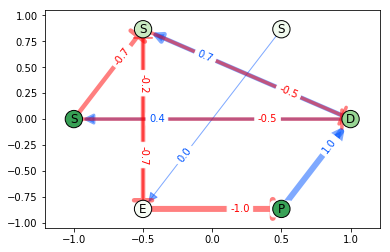

0.052884277133929854


In [1121]:
net = Host()


net.evolve(verbose=0)
net.visualize()



print(net.fitness_host)

# for _ in range(1000):
#     net.update()
# net.visualize()

# net.infect()

# print(net.network.nodes['P'])


# net.visualize()

# for _ in range(100):
#     net.update()
# net.visualize()
# print(net.network.nodes)

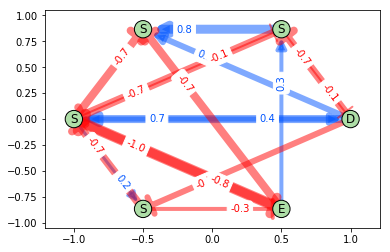

(-0.6545796586875376,
 0.4782678778168157,
 0.7056706629690552,
 -0.5188157703234053,
 -0.08812461228417834,
 0.8167194803457041,
 -0.6567716761584363,
 0.350820991549881,
 -0.12490534811243625,
 -0.7484678655761696,
 0.24271224737439923,
 -0.8264353909261919,
 -0.6957704412911327,
 -0.2583022672712103,
 0.27084278463725675,
 -0.7459697159597216,
 -0.9917384649601324)

In [973]:
n_nodes = 6
host_network = nx.binomial_graph(directed=True, n=n_nodes,p=0.5)

#### initialize


for node in host_network.nodes:
    host_network.nodes[node]['active'] = 0.5


for u,v,e in host_network.edges(data=True):
    e['weight'] = np.random.uniform(-1,1)

host_network.remove_edges_from([(0,n_nodes-1),(n_nodes-1,0)])




#### visualize

edges,weights = zip(*nx.get_edge_attributes(host_network,'weight').items())

activating = [e for e,w in nx.get_edge_attributes(host_network,'weight').items() if w > 0]
positive_weights = [round(w,1) for e,w in nx.get_edge_attributes(host_network,'weight').items() if w > 0]

deactivating = [e for e,w in nx.get_edge_attributes(host_network,'weight').items() if w < 0]
negative_weights = [round(w,1) for e,w in nx.get_edge_attributes(host_network,'weight').items() if w < 0]

active_ratios = list(nx.get_node_attributes(host_network,'active').values())

pos = nx.shell_layout(host_network)

graph_nodes = nx.draw_networkx_nodes(host_network, node_size=300, pos=pos, alpha=1, 
                       node_color= [a for a in active_ratios],
                                    cmap='Greens', vmin=0, vmax=1.5)  

graph_act_edges =nx.draw_networkx_edges(host_network, edgelist=activating,
                       pos=pos, width=[10*abs(w)+1 for w in positive_weights], arrowsize=20, edge_color= '#0055FF',
                        #edge_cmap= plt.cm.Blues, vmax=1, edge_color=positive_weights,
                        alpha=1)

graph_deact_edges = nx.draw_networkx_edges(host_network, edgelist=deactivating,
                       pos=pos, width=[10*abs(w)+1 for w in negative_weights], arrowsize=30, edge_color = '#FF0000',
                        #edge_cmap= plt.cm.Reds, edge_color=negative_weights,
                        alpha=0.6, arrowstyle=matplotlib.patches.ArrowStyle("|-|",widthA=0, widthB=0.3))

letters = ['D']+(host_network.number_of_nodes()-2)*['S']+['E']
labels = dict(zip(host_network.nodes,letters))

nx.draw_networkx_labels(host_network, pos=pos, 
                       labels = labels)
nx.draw_networkx_edge_labels(host_network, font_color='#0055FF', label_pos=0.3, pos=pos, edge_labels=dict(zip(activating,positive_weights)))
nx.draw_networkx_edge_labels(host_network, font_color='#FF0000', label_pos = 0.3, pos=pos, edge_labels=dict(zip(deactivating,negative_weights)))


#ax = plt.gca() # to get the current axis

graph_nodes.set_edgecolor('k')

for e in graph_act_edges+graph_deact_edges:
    e.set_alpha(0.5)

plt.show()

weights

In [1025]:
dict(list(zip(range(n_nodes), ['D']+list(range(n_nodes-2))+['E'])))

{0: 'D', 1: 0, 2: 1, 3: 2, 4: 3, 5: 'E'}